## 1. Data Loading & Preprocessing

In [1]:
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek

from transformers import (
    BertTokenizer, BertModel,
    RobertaTokenizer, RobertaModel,
    DistilBertTokenizer, DistilBertModel
)
import torch

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('iSarcasmEval_EN/train.En.csv', index_col=0)
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (3468, 9)

Columns: ['tweet', 'sarcastic', 'rephrase', 'sarcasm', 'irony', 'satire', 'understatement', 'overstatement', 'rhetorical_question']

First few rows:


,tweet,sarcastic,rephrase,sarcasm,irony,satire,understatement,overstatement,rhetorical_question
0,The only thing I got from college is a caffein...,1,"College is really difficult, expensive, tiring...",0.0,1.0,0.0,0.0,0.0,0.0
1,I love it when professors draw a big question ...,1,I do not like when professors don’t write out ...,1.0,0.0,0.0,0.0,0.0,0.0
2,Remember the hundred emails from companies whe...,1,"I, at the bare minimum, wish companies actuall...",0.0,1.0,0.0,0.0,0.0,0.0
3,Today my pop-pop told me I was not “forced” to...,1,"Today my pop-pop told me I was not ""forced"" to...",1.0,0.0,0.0,0.0,0.0,0.0
4,@VolphanCarol @littlewhitty @mysticalmanatee I...,1,I would say Ted Cruz is an asshole and doesn’t...,1.0,0.0,0.0,0.0,0.0,0.0


In [3]:
print("Class Distribution:")
print(df['sarcastic'].value_counts())
print("\nClass Balance:")
print(df['sarcastic'].value_counts(normalize=True) * 100)

Class Distribution:
sarcastic
0    2601
1     867
Name: count, dtype: int64

Class Balance:
sarcastic
0    75.0
1    25.0
Name: proportion, dtype: float64


In [4]:
def clean_text(text):
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
    
    text = re.sub(r'@(\w+)', '[USER]', text)
    
    text = re.sub(r'#(\w+)', r'\1', text)
    
    text = re.sub(r'(\!)\1{2,}', r'!!!', text)
    text = re.sub(r'(\?)\1{2,}', r'???', text)
    text = re.sub(r'(\.)\1{2,}', r'...', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

df['text_clean'] = df['tweet'].apply(clean_text)
print("✓ Text preprocessing complete")

✓ Text preprocessing complete


In [5]:
X = df['text_clean']
y = df['sarcastic']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"\nTraining set distribution:")
print(y_train.value_counts(normalize=True))
print(f"\nValidation set distribution:")
print(y_val.value_counts(normalize=True))

Training set size: 2774
Validation set size: 694

Training set distribution:
sarcastic
0    0.74982
1    0.25018
Name: proportion, dtype: float64

Validation set distribution:
sarcastic
0    0.75072
1    0.24928
Name: proportion, dtype: float64



## 2. Feature Extraction Methods

### 2.1 TF-IDF Features

In [6]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 3),  
    stop_words='english'
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

print(f"✓ TF-IDF features extracted\n")
print(f"Feature shape: {X_train_tfidf.shape}")
print(f"Number of features: {len(tfidf_vectorizer.get_feature_names_out())}")
print(f"Sparsity: {(1.0 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])) * 100:.2f}%")

✓ TF-IDF features extracted

Feature shape: (2774, 3856)
Number of features: 3856
Sparsity: 99.79%


### 2.2 BERT Embeddings

In [7]:
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
bert_model = bert_model.to(device)
print(f"✓ BERT loaded on {device}")

✓ BERT loaded on cuda


In [8]:
def get_bert_embeddings(texts, tokenizer, model, batch_size=32):
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()
        
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            truncation=True,
            max_length=128,
            padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {i+len(batch_texts)}/{len(texts)} texts")
    
    return np.vstack(embeddings)

print("Extracting BERT embeddings for training set")
X_train_bert = get_bert_embeddings(X_train, bert_tokenizer, bert_model)
print("\nExtracting BERT embeddings for validation set")
X_val_bert = get_bert_embeddings(X_val, bert_tokenizer, bert_model)

print(f"\n✓ BERT embeddings extracted\n")
print(f"Training embeddings shape: {X_train_bert.shape}")
print(f"Validation embeddings shape: {X_val_bert.shape}")

Extracting BERT embeddings for training set
  Processed 320/2774 texts
  Processed 320/2774 texts
  Processed 640/2774 texts
  Processed 640/2774 texts
  Processed 960/2774 texts
  Processed 960/2774 texts
  Processed 1280/2774 texts
  Processed 1280/2774 texts
  Processed 1600/2774 texts
  Processed 1600/2774 texts
  Processed 1920/2774 texts
  Processed 1920/2774 texts
  Processed 2240/2774 texts
  Processed 2240/2774 texts
  Processed 2560/2774 texts
  Processed 2560/2774 texts

Extracting BERT embeddings for validation set

Extracting BERT embeddings for validation set
  Processed 320/694 texts
  Processed 320/694 texts
  Processed 640/694 texts
  Processed 640/694 texts

✓ BERT embeddings extracted

Training embeddings shape: (2774, 768)
Validation embeddings shape: (694, 768)

✓ BERT embeddings extracted

Training embeddings shape: (2774, 768)
Validation embeddings shape: (694, 768)


### 2.3 RoBERTa Embeddings

In [9]:
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = RobertaModel.from_pretrained('roberta-base')
roberta_model.eval()
roberta_model = roberta_model.to(device)
print(f"✓ RoBERTa loaded on {device}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ RoBERTa loaded on cuda


In [10]:
def get_roberta_embeddings(texts, tokenizer, model, batch_size=32):
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()
        
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            truncation=True,
            max_length=128,
            padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {i+len(batch_texts)}/{len(texts)} texts")
    
    return np.vstack(embeddings)

print("Extracting RoBERTa embeddings for training set")
X_train_roberta = get_roberta_embeddings(X_train, roberta_tokenizer, roberta_model)
print("\nExtracting RoBERTa embeddings for validation set")
X_val_roberta = get_roberta_embeddings(X_val, roberta_tokenizer, roberta_model)

print(f"\n✓ RoBERTa embeddings extracted\n")
print(f"Training embeddings shape: {X_train_roberta.shape}")
print(f"Validation embeddings shape: {X_val_roberta.shape}")

Extracting RoBERTa embeddings for training set
  Processed 320/2774 texts
  Processed 320/2774 texts
  Processed 640/2774 texts
  Processed 640/2774 texts
  Processed 960/2774 texts
  Processed 960/2774 texts
  Processed 1280/2774 texts
  Processed 1280/2774 texts
  Processed 1600/2774 texts
  Processed 1600/2774 texts
  Processed 1920/2774 texts
  Processed 1920/2774 texts
  Processed 2240/2774 texts
  Processed 2240/2774 texts
  Processed 2560/2774 texts
  Processed 2560/2774 texts

Extracting RoBERTa embeddings for validation set

Extracting RoBERTa embeddings for validation set
  Processed 320/694 texts
  Processed 320/694 texts
  Processed 640/694 texts
  Processed 640/694 texts

✓ RoBERTa embeddings extracted

Training embeddings shape: (2774, 768)
Validation embeddings shape: (694, 768)

✓ RoBERTa embeddings extracted

Training embeddings shape: (2774, 768)
Validation embeddings shape: (694, 768)


### 2.4 DistilBERT Embeddings

In [11]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
distilbert_model.eval()
distilbert_model = distilbert_model.to(device)
print(f"✓ DistilBERT loaded on {device}")

✓ DistilBERT loaded on cuda


In [12]:
def get_distilbert_embeddings(texts, tokenizer, model, batch_size=32):
    embeddings = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size].tolist()
        
        inputs = tokenizer(
            batch_texts,
            return_tensors='pt',
            truncation=True,
            max_length=128,
            padding=True
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
        
        if (i // batch_size + 1) % 10 == 0:
            print(f"  Processed {i+len(batch_texts)}/{len(texts)} texts")
    
    return np.vstack(embeddings)

print("Extracting DistilBERT embeddings for training set")
X_train_distilbert = get_distilbert_embeddings(X_train, distilbert_tokenizer, distilbert_model)
print("\nExtracting DistilBERT embeddings for validation set")
X_val_distilbert = get_distilbert_embeddings(X_val, distilbert_tokenizer, distilbert_model)

print(f"\n✓ DistilBERT embeddings extracted\n")
print(f"Training embeddings shape: {X_train_distilbert.shape}")
print(f"Validation embeddings shape: {X_val_distilbert.shape}")

Extracting DistilBERT embeddings for training set
  Processed 320/2774 texts
  Processed 320/2774 texts
  Processed 640/2774 texts
  Processed 640/2774 texts
  Processed 960/2774 texts
  Processed 960/2774 texts
  Processed 1280/2774 texts
  Processed 1280/2774 texts
  Processed 1600/2774 texts
  Processed 1600/2774 texts
  Processed 1920/2774 texts
  Processed 1920/2774 texts
  Processed 2240/2774 texts
  Processed 2240/2774 texts
  Processed 2560/2774 texts
  Processed 2560/2774 texts

Extracting DistilBERT embeddings for validation set

Extracting DistilBERT embeddings for validation set
  Processed 320/694 texts
  Processed 320/694 texts
  Processed 640/694 texts
  Processed 640/694 texts

✓ DistilBERT embeddings extracted

Training embeddings shape: (2774, 768)
Validation embeddings shape: (694, 768)

✓ DistilBERT embeddings extracted

Training embeddings shape: (2774, 768)
Validation embeddings shape: (694, 768)



## 3. Sampling Techniques

In [13]:
sampling_techniques = {}

def apply_sampling(X_train_features, y_train, technique_name, sampler):
    print(f"\nApplying {technique_name}...")
    print(f"Before: {pd.Series(y_train).value_counts().to_dict()}")
    
    X_resampled, y_resampled = sampler.fit_resample(X_train_features, y_train)
    
    print(f"After: {pd.Series(y_resampled).value_counts().to_dict()}")
    print(f"✓ {technique_name} complete")
    
    return X_resampled, y_resampled

### 3.1 Baseline (No Sampling)

In [14]:
print(f"Class distribution: {pd.Series(y_train).value_counts().to_dict()}")
sampling_techniques['baseline'] = {
    'tfidf': (X_train_tfidf, y_train),
    'bert': (X_train_bert, y_train),
    'roberta': (X_train_roberta, y_train),
    'distilbert': (X_train_distilbert, y_train)
}

Class distribution: {0: 2080, 1: 694}


### 3.2 Random Under-Sampling

In [15]:
rus = RandomUnderSampler(random_state=42)

sampling_techniques['under_sampling'] = {
    'tfidf': apply_sampling(X_train_tfidf, y_train, "Under-Sampling (TF-IDF)", rus),
    'bert': apply_sampling(X_train_bert, y_train, "Under-Sampling (BERT)", RandomUnderSampler(random_state=42)),
    'roberta': apply_sampling(X_train_roberta, y_train, "Under-Sampling (RoBERTa)", RandomUnderSampler(random_state=42)),
    'distilbert': apply_sampling(X_train_distilbert, y_train, "Under-Sampling (DistilBERT)", RandomUnderSampler(random_state=42))
}


Applying Under-Sampling (TF-IDF)...
Before: {0: 2080, 1: 694}
After: {0: 694, 1: 694}
✓ Under-Sampling (TF-IDF) complete

Applying Under-Sampling (BERT)...
Before: {0: 2080, 1: 694}
After: {0: 694, 1: 694}
✓ Under-Sampling (BERT) complete

Applying Under-Sampling (RoBERTa)...
Before: {0: 2080, 1: 694}
After: {0: 694, 1: 694}
✓ Under-Sampling (RoBERTa) complete

Applying Under-Sampling (DistilBERT)...
Before: {0: 2080, 1: 694}
After: {0: 694, 1: 694}
✓ Under-Sampling (DistilBERT) complete


### 3.3 Random Over-Sampling

In [16]:
ros = RandomOverSampler(random_state=42)

sampling_techniques['over_sampling'] = {
    'tfidf': apply_sampling(X_train_tfidf, y_train, "Over-Sampling (TF-IDF)", ros),
    'bert': apply_sampling(X_train_bert, y_train, "Over-Sampling (BERT)", RandomOverSampler(random_state=42)),
    'roberta': apply_sampling(X_train_roberta, y_train, "Over-Sampling (RoBERTa)", RandomOverSampler(random_state=42)),
    'distilbert': apply_sampling(X_train_distilbert, y_train, "Over-Sampling (DistilBERT)", RandomOverSampler(random_state=42))
}


Applying Over-Sampling (TF-IDF)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ Over-Sampling (TF-IDF) complete

Applying Over-Sampling (BERT)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ Over-Sampling (BERT) complete

Applying Over-Sampling (RoBERTa)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ Over-Sampling (RoBERTa) complete

Applying Over-Sampling (DistilBERT)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ Over-Sampling (DistilBERT) complete
After: {1: 2080, 0: 2080}
✓ Over-Sampling (TF-IDF) complete

Applying Over-Sampling (BERT)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ Over-Sampling (BERT) complete

Applying Over-Sampling (RoBERTa)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ Over-Sampling (RoBERTa) complete

Applying Over-Sampling (DistilBERT)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ Over-Sampling (DistilBERT) complete


### 3.4 SMOTE (Synthetic Minority Over-sampling)

In [17]:
smote = SMOTE(random_state=42)

sampling_techniques['smote'] = {
    'tfidf': apply_sampling(X_train_tfidf, y_train, "SMOTE (TF-IDF)", smote),
    'bert': apply_sampling(X_train_bert, y_train, "SMOTE (BERT)", SMOTE(random_state=42)),
    'roberta': apply_sampling(X_train_roberta, y_train, "SMOTE (RoBERTa)", SMOTE(random_state=42)),
    'distilbert': apply_sampling(X_train_distilbert, y_train, "SMOTE (DistilBERT)", SMOTE(random_state=42))
}


Applying SMOTE (TF-IDF)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ SMOTE (TF-IDF) complete

Applying SMOTE (BERT)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ SMOTE (BERT) complete

Applying SMOTE (RoBERTa)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ SMOTE (RoBERTa) complete

Applying SMOTE (DistilBERT)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ SMOTE (BERT) complete

Applying SMOTE (RoBERTa)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ SMOTE (RoBERTa) complete

Applying SMOTE (DistilBERT)...
Before: {0: 2080, 1: 694}
After: {1: 2080, 0: 2080}
✓ SMOTE (DistilBERT) complete
After: {1: 2080, 0: 2080}
✓ SMOTE (DistilBERT) complete



## 4. Model Evaluation

In [18]:
results = []

def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, feature_name, sampling_name):
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    
    return {
        'Model': model_name,
        'Features': feature_name,
        'Sampling': sampling_name,
        'Accuracy': accuracy,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall
    }

### 4.1 Logistic Regression

In [19]:
print("Training Logistic Regression models...\n")

val_data = {
    'tfidf': X_val_tfidf,
    'bert': X_val_bert,
    'roberta': X_val_roberta,
    'distilbert': X_val_distilbert
}

for sampling_name, sampling_data in sampling_techniques.items():
    for feature_name in ['tfidf', 'bert', 'roberta', 'distilbert']:
        X_train_sample, y_train_sample = sampling_data[feature_name]
        
        model = LogisticRegression(
            max_iter=1000,
            random_state=42,
            class_weight='balanced' if sampling_name == 'baseline' else None
        )
        
        result = evaluate_model(
            model, X_train_sample, y_train_sample,
            val_data[feature_name], y_val,
            'Logistic Regression', feature_name.upper(), sampling_name
        )
        results.append(result)
        print(f"✓ LR | {feature_name.upper():10s} | {sampling_name:15s} | F1: {result['F1-Score']:.4f}")

print("\n✓ Logistic Regression evaluation complete")

Training Logistic Regression models...

✓ LR | TFIDF      | baseline        | F1: 0.3315
✓ LR | BERT       | baseline        | F1: 0.3971
✓ LR | BERT       | baseline        | F1: 0.3971
✓ LR | ROBERTA    | baseline        | F1: 0.4483
✓ LR | ROBERTA    | baseline        | F1: 0.4483
✓ LR | DISTILBERT | baseline        | F1: 0.4045
✓ LR | TFIDF      | under_sampling  | F1: 0.3740
✓ LR | DISTILBERT | baseline        | F1: 0.4045
✓ LR | TFIDF      | under_sampling  | F1: 0.3740
✓ LR | BERT       | under_sampling  | F1: 0.4182
✓ LR | BERT       | under_sampling  | F1: 0.4182
✓ LR | ROBERTA    | under_sampling  | F1: 0.4512
✓ LR | ROBERTA    | under_sampling  | F1: 0.4512
✓ LR | DISTILBERT | under_sampling  | F1: 0.4096
✓ LR | TFIDF      | over_sampling   | F1: 0.2865
✓ LR | DISTILBERT | under_sampling  | F1: 0.4096
✓ LR | TFIDF      | over_sampling   | F1: 0.2865
✓ LR | BERT       | over_sampling   | F1: 0.4099
✓ LR | BERT       | over_sampling   | F1: 0.4099
✓ LR | ROBERTA    | over_samp

### 4.2 Random Forest

In [20]:
print("Training Random Forest models...\n")

for sampling_name, sampling_data in sampling_techniques.items():
    for feature_name in ['tfidf', 'bert', 'roberta', 'distilbert']:
        X_train_sample, y_train_sample = sampling_data[feature_name]
        
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=20,
            random_state=42,
            n_jobs=-1,
            class_weight='balanced' if sampling_name == 'baseline' else None
        )
        
        result = evaluate_model(
            model, X_train_sample, y_train_sample,
            val_data[feature_name], y_val,
            'Random Forest', feature_name.upper(), sampling_name
        )
        results.append(result)
        print(f"✓ RF | {feature_name.upper():10s} | {sampling_name:15s} | F1: {result['F1-Score']:.4f}")

print("\n✓ Random Forest evaluation complete")

Training Random Forest models...

✓ RF | TFIDF      | baseline        | F1: 0.2647
✓ RF | TFIDF      | baseline        | F1: 0.2647
✓ RF | BERT       | baseline        | F1: 0.0114
✓ RF | BERT       | baseline        | F1: 0.0114
✓ RF | ROBERTA    | baseline        | F1: 0.0115
✓ RF | ROBERTA    | baseline        | F1: 0.0115
✓ RF | DISTILBERT | baseline        | F1: 0.0115
✓ RF | DISTILBERT | baseline        | F1: 0.0115
✓ RF | TFIDF      | under_sampling  | F1: 0.3766
✓ RF | TFIDF      | under_sampling  | F1: 0.3766
✓ RF | BERT       | under_sampling  | F1: 0.3651
✓ RF | BERT       | under_sampling  | F1: 0.3651
✓ RF | ROBERTA    | under_sampling  | F1: 0.4211
✓ RF | ROBERTA    | under_sampling  | F1: 0.4211
✓ RF | DISTILBERT | under_sampling  | F1: 0.4325
✓ RF | DISTILBERT | under_sampling  | F1: 0.4325
✓ RF | TFIDF      | over_sampling   | F1: 0.2990
✓ RF | TFIDF      | over_sampling   | F1: 0.2990
✓ RF | BERT       | over_sampling   | F1: 0.0667
✓ RF | BERT       | over_sampling  

### 4.3 XGBoost

In [21]:
print("Training XGBoost models...\n")

for sampling_name, sampling_data in sampling_techniques.items():
    for feature_name in ['tfidf', 'bert', 'roberta', 'distilbert']:
        X_train_sample, y_train_sample = sampling_data[feature_name]
        
        if sampling_name == 'baseline':
            scale_pos_weight = (y_train_sample == 0).sum() / (y_train_sample == 1).sum()
        else:
            scale_pos_weight = 1
        
        model = XGBClassifier(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            scale_pos_weight=scale_pos_weight,
            random_state=42,
            use_label_encoder=False,
            eval_metric='logloss'
        )
        
        result = evaluate_model(
            model, X_train_sample, y_train_sample,
            val_data[feature_name], y_val,
            'XGBoost', feature_name.upper(), sampling_name
        )
        results.append(result)
        print(f"✓ XGB | {feature_name.upper():10s} | {sampling_name:15s} | F1: {result['F1-Score']:.4f}")

print("\n✓ XGBoost evaluation complete")

Training XGBoost models...

✓ XGB | TFIDF      | baseline        | F1: 0.3028
✓ XGB | TFIDF      | baseline        | F1: 0.3028
✓ XGB | BERT       | baseline        | F1: 0.2275
✓ XGB | BERT       | baseline        | F1: 0.2275
✓ XGB | ROBERTA    | baseline        | F1: 0.2912
✓ XGB | ROBERTA    | baseline        | F1: 0.2912
✓ XGB | DISTILBERT | baseline        | F1: 0.2738
✓ XGB | DISTILBERT | baseline        | F1: 0.2738
✓ XGB | TFIDF      | under_sampling  | F1: 0.3538
✓ XGB | TFIDF      | under_sampling  | F1: 0.3538
✓ XGB | BERT       | under_sampling  | F1: 0.3836
✓ XGB | BERT       | under_sampling  | F1: 0.3836
✓ XGB | ROBERTA    | under_sampling  | F1: 0.4677
✓ XGB | ROBERTA    | under_sampling  | F1: 0.4677
✓ XGB | DISTILBERT | under_sampling  | F1: 0.4142
✓ XGB | DISTILBERT | under_sampling  | F1: 0.4142
✓ XGB | TFIDF      | over_sampling   | F1: 0.3131
✓ XGB | TFIDF      | over_sampling   | F1: 0.3131
✓ XGB | BERT       | over_sampling   | F1: 0.2547
✓ XGB | BERT       | o

### 4.4 Support Vector Machine

In [22]:
print("Training SVM models...\n")

for sampling_name, sampling_data in sampling_techniques.items():
    for feature_name in ['tfidf', 'bert', 'roberta', 'distilbert']:
        X_train_sample, y_train_sample = sampling_data[feature_name]
        
        model = SVC(
            kernel='rbf',
            C=1.0,
            random_state=42,
            class_weight='balanced' if sampling_name == 'baseline' else None
        )
        
        result = evaluate_model(
            model, X_train_sample, y_train_sample,
            val_data[feature_name], y_val,
            'SVM', feature_name.upper(), sampling_name
        )
        results.append(result)
        print(f"✓ SVM | {feature_name.upper():10s} | {sampling_name:15s} | F1: {result['F1-Score']:.4f}")

print("\n✓ SVM evaluation complete")

Training SVM models...

✓ SVM | TFIDF      | baseline        | F1: 0.2023
✓ SVM | TFIDF      | baseline        | F1: 0.2023
✓ SVM | BERT       | baseline        | F1: 0.4087
✓ SVM | BERT       | baseline        | F1: 0.4087
✓ SVM | ROBERTA    | baseline        | F1: 0.3957
✓ SVM | ROBERTA    | baseline        | F1: 0.3957
✓ SVM | DISTILBERT | baseline        | F1: 0.3983
✓ SVM | DISTILBERT | baseline        | F1: 0.3983
✓ SVM | TFIDF      | under_sampling  | F1: 0.3740
✓ SVM | TFIDF      | under_sampling  | F1: 0.3740
✓ SVM | BERT       | under_sampling  | F1: 0.4245
✓ SVM | BERT       | under_sampling  | F1: 0.4245
✓ SVM | ROBERTA    | under_sampling  | F1: 0.4637
✓ SVM | ROBERTA    | under_sampling  | F1: 0.4637
✓ SVM | DISTILBERT | under_sampling  | F1: 0.4326
✓ SVM | DISTILBERT | under_sampling  | F1: 0.4326
✓ SVM | TFIDF      | over_sampling   | F1: 0.1545
✓ SVM | TFIDF      | over_sampling   | F1: 0.1545
✓ SVM | BERT       | over_sampling   | F1: 0.4054
✓ SVM | BERT       | over_

### 4.5 K-Nearest Neighbors

In [23]:
print("Training KNN models...\n")

for sampling_name, sampling_data in sampling_techniques.items():
    for feature_name in ['tfidf', 'bert', 'roberta', 'distilbert']:
        X_train_sample, y_train_sample = sampling_data[feature_name]
        
        model = KNeighborsClassifier(
            n_neighbors=5,
            weights='distance',
            n_jobs=-1
        )
        
        result = evaluate_model(
            model, X_train_sample, y_train_sample,
            val_data[feature_name], y_val,
            'KNN', feature_name.upper(), sampling_name
        )
        results.append(result)
        print(f"✓ KNN | {feature_name.upper():10s} | {sampling_name:15s} | F1: {result['F1-Score']:.4f}")

print("\n✓ KNN evaluation complete")

Training KNN models...

✓ KNN | TFIDF      | baseline        | F1: 0.1010
✓ KNN | BERT       | baseline        | F1: 0.2340
✓ KNN | ROBERTA    | baseline        | F1: 0.2115
✓ KNN | DISTILBERT | baseline        | F1: 0.1897
✓ KNN | TFIDF      | under_sampling  | F1: 0.3115
✓ KNN | BERT       | under_sampling  | F1: 0.3940
✓ KNN | ROBERTA    | under_sampling  | F1: 0.3624
✓ KNN | DISTILBERT | under_sampling  | F1: 0.3609
✓ KNN | TFIDF      | over_sampling   | F1: 0.3315
✓ KNN | BERT       | over_sampling   | F1: 0.3722
✓ KNN | ROBERTA    | over_sampling   | F1: 0.3253
✓ KNN | DISTILBERT | over_sampling   | F1: 0.3768
✓ KNN | TFIDF      | smote           | F1: 0.3976
✓ KNN | BERT       | smote           | F1: 0.4085
✓ KNN | ROBERTA    | smote           | F1: 0.4185
✓ KNN | DISTILBERT | smote           | F1: 0.3995

✓ KNN evaluation complete


### 4.6 Naive Bayes

In [24]:
print("Training Naive Bayes models...\n")

for sampling_name, sampling_data in sampling_techniques.items():
    for feature_name in ['tfidf', 'bert', 'roberta', 'distilbert']:
        X_train_sample, y_train_sample = sampling_data[feature_name]
        
        # Use MultinomialNB for TF-IDF (sparse, non-negative features)
        # Use GaussianNB for BERT embeddings (dense features that can be negative)
        if feature_name == 'tfidf':
            model = MultinomialNB()
        else:
            model = GaussianNB()
        
        result = evaluate_model(
            model, X_train_sample, y_train_sample,
            val_data[feature_name], y_val,
            'Naive Bayes', feature_name.upper(), sampling_name
        )
        results.append(result)
        print(f"✓ NB  | {feature_name.upper():10s} | {sampling_name:15s} | F1: {result['F1-Score']:.4f}")

print("\n✓ Naive Bayes evaluation complete")

Training Naive Bayes models...

✓ NB  | TFIDF      | baseline        | F1: 0.0226
✓ NB  | BERT       | baseline        | F1: 0.3934
✓ NB  | ROBERTA    | baseline        | F1: 0.4391
✓ NB  | DISTILBERT | baseline        | F1: 0.4390
✓ NB  | TFIDF      | under_sampling  | F1: 0.3478
✓ NB  | BERT       | under_sampling  | F1: 0.4073
✓ NB  | ROBERTA    | under_sampling  | F1: 0.4422
✓ NB  | DISTILBERT | under_sampling  | F1: 0.4104
✓ NB  | TFIDF      | over_sampling   | F1: 0.3462
✓ NB  | BERT       | over_sampling   | F1: 0.4198
✓ NB  | ROBERTA    | over_sampling   | F1: 0.4490
✓ NB  | DISTILBERT | over_sampling   | F1: 0.4277
✓ NB  | TFIDF      | smote           | F1: 0.3429
✓ NB  | BERT       | smote           | F1: 0.3808
✓ NB  | ROBERTA    | smote           | F1: 0.3885
✓ NB  | DISTILBERT | smote           | F1: 0.3863

✓ Naive Bayes evaluation complete



## 5. Results Comparison

In [25]:
results_df = pd.DataFrame(results)
results_df = results_df.round(4)


print("COMPREHENSIVE RESULTS SUMMARY\n")

print(results_df.to_string(index=False))

results_df.to_csv('comprehensive_model_results.csv', index=False)
print("\n✓ Results saved to 'comprehensive_model_results.csv'")

COMPREHENSIVE RESULTS SUMMARY

              Model   Features       Sampling  Accuracy  F1-Score  Precision  Recall
Logistic Regression      TFIDF       baseline    0.6455    0.3315     0.3128  0.3526
Logistic Regression       BERT       baseline    0.6412    0.3971     0.3417  0.4740
Logistic Regression    ROBERTA       baseline    0.6311    0.4483     0.3574  0.6012
Logistic Regression DISTILBERT       baseline    0.6182    0.4045     0.3309  0.5202
Logistic Regression      TFIDF under_sampling    0.5418    0.3740     0.2836  0.5491
Logistic Regression       BERT under_sampling    0.5951    0.4182     0.3258  0.5838
Logistic Regression    ROBERTA under_sampling    0.6110    0.4512     0.3480  0.6416
Logistic Regression DISTILBERT under_sampling    0.5764    0.4096     0.3138  0.5896
Logistic Regression      TFIDF  over_sampling    0.6412    0.2865     0.2841  0.2890
Logistic Regression       BERT  over_sampling    0.6556    0.4099     0.3578  0.4798
Logistic Regression    ROBERTA  ov

In [26]:
print("TOP 10 MODELS BY F1-SCORE")

top_f1 = results_df.nlargest(10, 'F1-Score')
print(top_f1.to_string(index=False))

TOP 10 MODELS BY F1-SCORE
              Model   Features       Sampling  Accuracy  F1-Score  Precision  Recall
            XGBoost    ROBERTA under_sampling    0.6196    0.4677     0.3591  0.6705
                SVM    ROBERTA under_sampling    0.5634    0.4637     0.3342  0.7572
Logistic Regression    ROBERTA  over_sampling    0.6542    0.4619     0.3773  0.5954
Logistic Regression    ROBERTA          smote    0.6527    0.4609     0.3759  0.5954
Logistic Regression    ROBERTA under_sampling    0.6110    0.4512     0.3480  0.6416
        Naive Bayes    ROBERTA  over_sampling    0.6110    0.4490     0.3470  0.6358
Logistic Regression    ROBERTA       baseline    0.6311    0.4483     0.3574  0.6012
        Naive Bayes    ROBERTA under_sampling    0.5965    0.4422     0.3374  0.6416
        Naive Bayes    ROBERTA       baseline    0.5620    0.4391     0.3225  0.6879
        Naive Bayes DISTILBERT       baseline    0.6023    0.4390     0.3386  0.6243


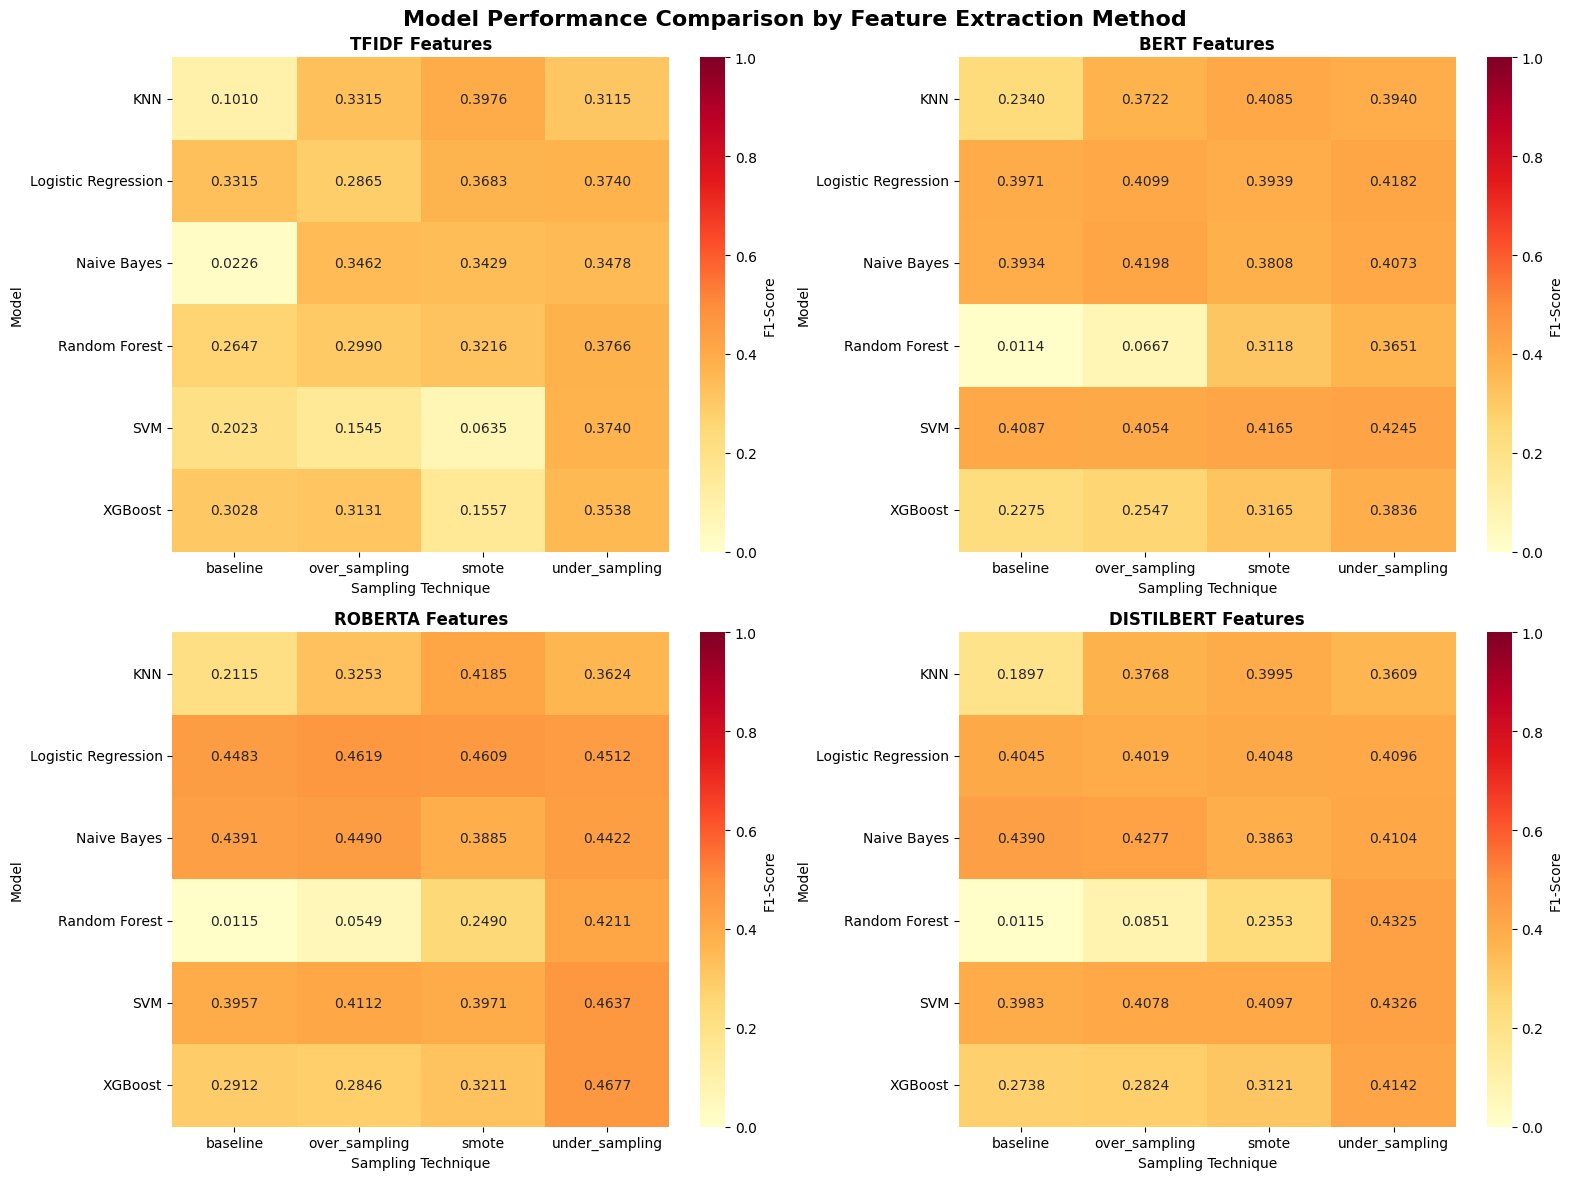

In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison by Feature Extraction Method', fontsize=16, fontweight='bold')

feature_methods = ['TFIDF', 'BERT', 'ROBERTA', 'DISTILBERT']

for idx, feature in enumerate(feature_methods):
    ax = axes[idx // 2, idx % 2]
    
    feature_data = results_df[results_df['Features'] == feature]
    
    pivot_data = feature_data.pivot_table(
        values='F1-Score',
        index='Model',
        columns='Sampling',
        aggfunc='mean'
    )
    
    sns.heatmap(pivot_data, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax, 
                vmin=0, vmax=1, cbar_kws={'label': 'F1-Score'})
    ax.set_title(f'{feature} Features', fontweight='bold')
    ax.set_xlabel('Sampling Technique')
    ax.set_ylabel('Model')

plt.tight_layout()
plt.savefig('model_comparison_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

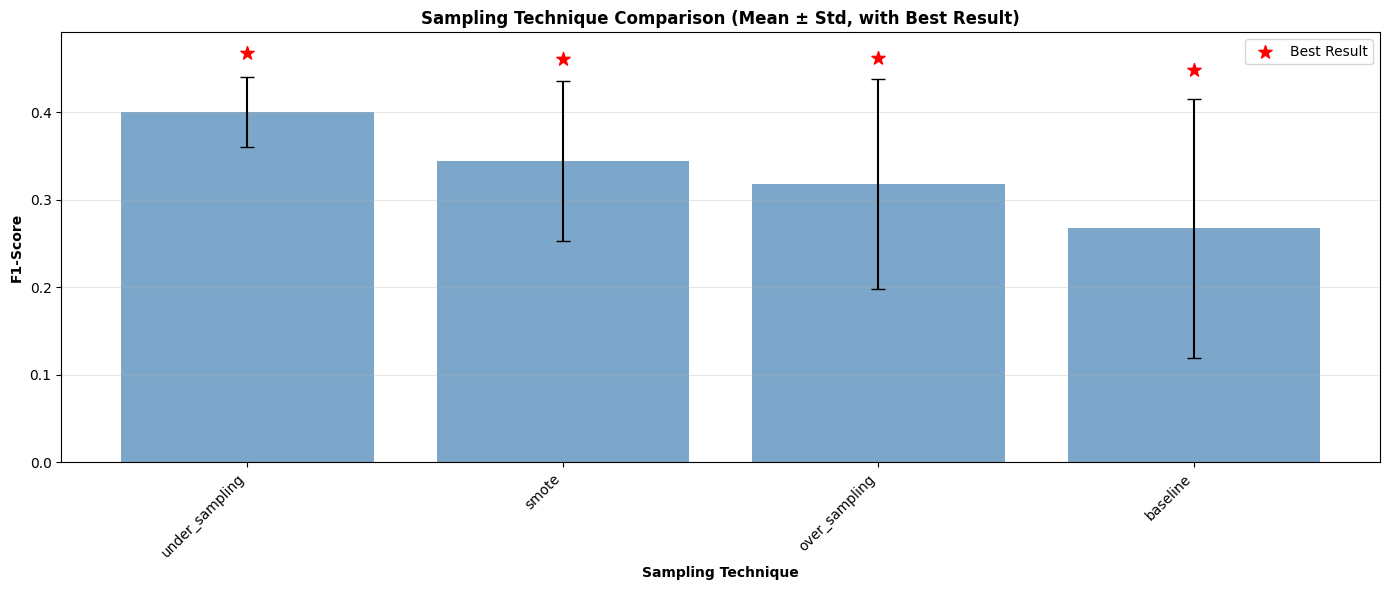

In [28]:
plt.figure(figsize=(14, 6))

sampling_performance = results_df.groupby('Sampling')['F1-Score'].agg(['mean', 'std', 'max'])
sampling_performance = sampling_performance.sort_values('mean', ascending=False)

x = range(len(sampling_performance))
plt.bar(x, sampling_performance['mean'], yerr=sampling_performance['std'], 
        alpha=0.7, capsize=5, color='steelblue')
plt.scatter(x, sampling_performance['max'], color='red', s=100, 
           label='Best Result', zorder=5, marker='*')

plt.xlabel('Sampling Technique', fontweight='bold')
plt.ylabel('F1-Score', fontweight='bold')
plt.title('Sampling Technique Comparison (Mean ± Std, with Best Result)', fontweight='bold')
plt.xticks(x, sampling_performance.index, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('sampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

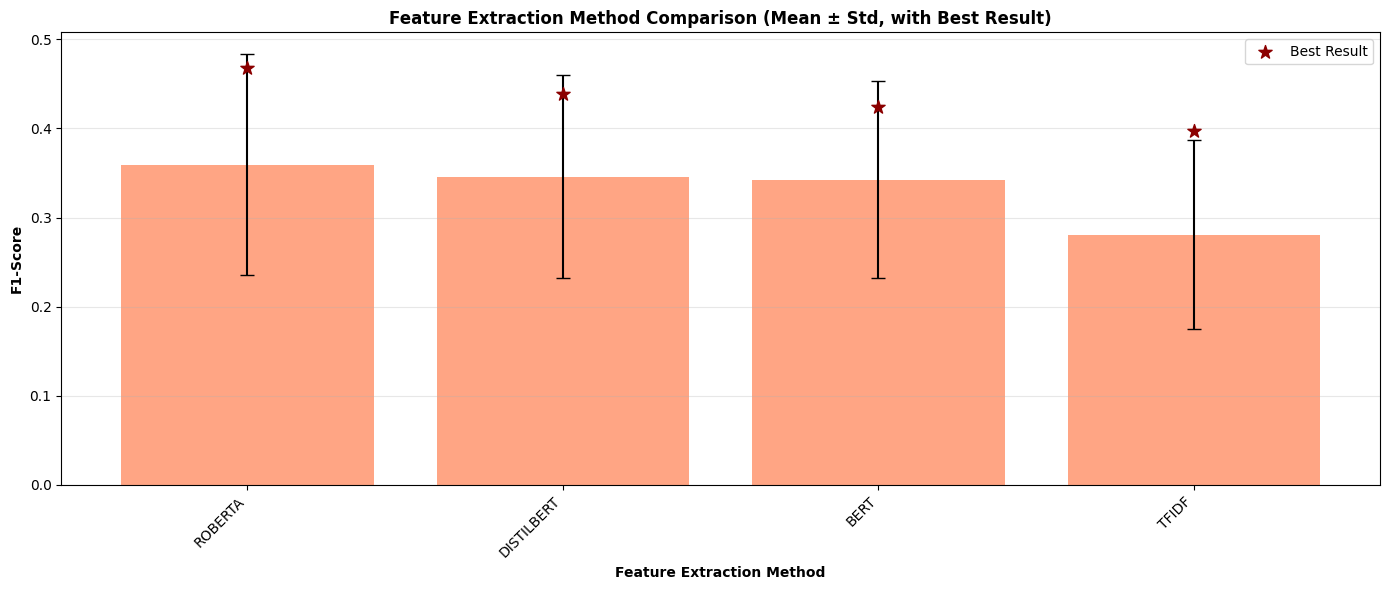

In [29]:
plt.figure(figsize=(14, 6))

feature_performance = results_df.groupby('Features')['F1-Score'].agg(['mean', 'std', 'max'])
feature_performance = feature_performance.sort_values('mean', ascending=False)

x = range(len(feature_performance))
plt.bar(x, feature_performance['mean'], yerr=feature_performance['std'], 
        alpha=0.7, capsize=5, color='coral')
plt.scatter(x, feature_performance['max'], color='darkred', s=100, 
           label='Best Result', zorder=5, marker='*')

plt.xlabel('Feature Extraction Method', fontweight='bold')
plt.ylabel('F1-Score', fontweight='bold')
plt.title('Feature Extraction Method Comparison (Mean ± Std, with Best Result)', fontweight='bold')
plt.xticks(x, feature_performance.index, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('feature_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

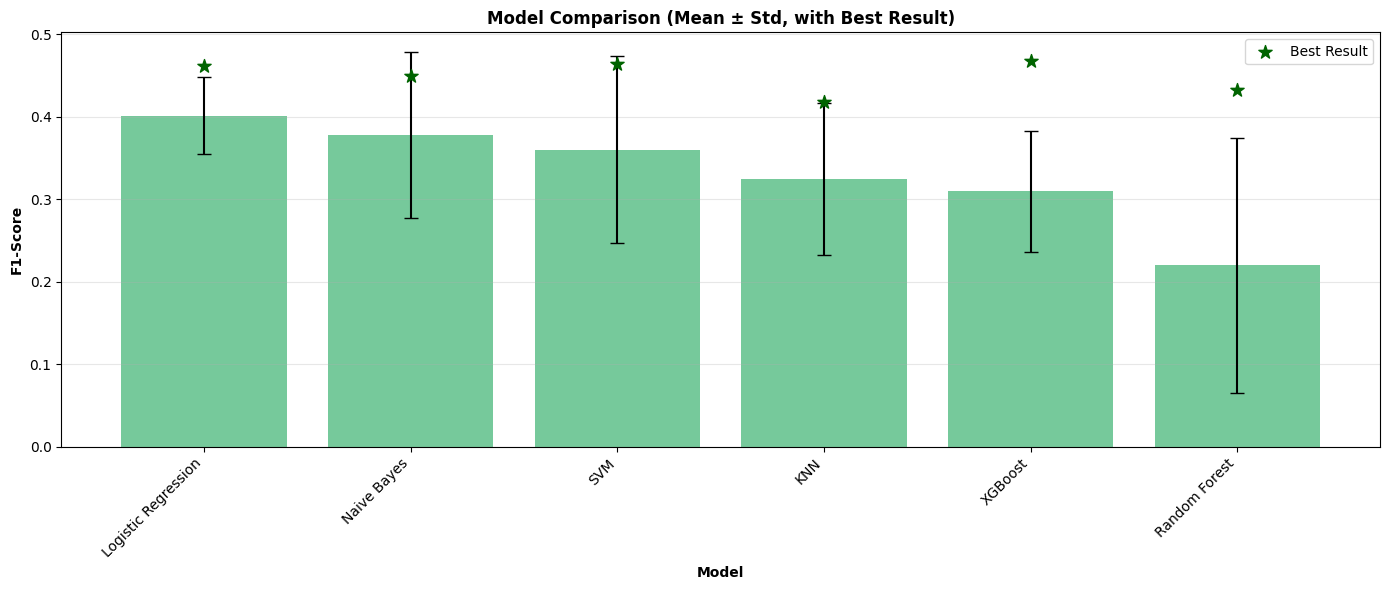

In [30]:
plt.figure(figsize=(14, 6))

model_performance = results_df.groupby('Model')['F1-Score'].agg(['mean', 'std', 'max'])
model_performance = model_performance.sort_values('mean', ascending=False)

x = range(len(model_performance))
plt.bar(x, model_performance['mean'], yerr=model_performance['std'], 
        alpha=0.7, capsize=5, color='mediumseagreen')
plt.scatter(x, model_performance['max'], color='darkgreen', s=100, 
           label='Best Result', zorder=5, marker='*')

plt.xlabel('Model', fontweight='bold')
plt.ylabel('F1-Score', fontweight='bold')
plt.title('Model Comparison (Mean ± Std, with Best Result)', fontweight='bold')
plt.xticks(x, model_performance.index, rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
best_model = results_df.loc[results_df['F1-Score'].idxmax()]

print("BEST OVERALL CONFIGURATION")
print(f"Model:           {best_model['Model']}")
print(f"Features:        {best_model['Features']}")
print(f"Sampling:        {best_model['Sampling']}")
print(f"Accuracy:        {best_model['Accuracy']:.4f}")
print(f"F1-Score:        {best_model['F1-Score']:.4f}")
print(f"Precision:       {best_model['Precision']:.4f}")
print(f"Recall:          {best_model['Recall']:.4f}")

BEST OVERALL CONFIGURATION
Model:           XGBoost
Features:        ROBERTA
Sampling:        under_sampling
Accuracy:        0.6196
F1-Score:        0.4677
Precision:       0.3591
Recall:          0.6705
